# References

### [sklearn]
- https://www.kaggle.com/mchirico/quick-look-seaborn-wordcloud
- https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

### [pytorch]
- https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from io import StringIO
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from text_processing import text_preprocessing
from wordcloud import WordCloud

# Data Preparation

- train-test split
- batch-loading
- data preparation for MIMIC from postgres
- null handling = sMOTE or other conventional methods
- auxilliary data for netflix needs to be collected

### Dataset 01: Titanic
- source: https://www.kaggle.com/c/titanic/data
- predict the survival based on passenger information

In [4]:
df_data = pd.read_csv('data/titanic.csv')
len_prev = len(df_data)
df_data.drop(['Cabin'], axis=1, inplace=True)
df_data.dropna(inplace=True)
len_curr = len(df_data)
print("{} rows with null values dropped".format(len_prev-len_curr))
print("{} rows of data available".format(len_curr))
df_data.head(3)

179 rows with null values dropped
712 rows of data available


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


### Text Preprocessing
- making text case insensitive
- handling special characters
- can possibly help match more columns in case of noisy data 
- standardize the categorical columns to prevent more dummy variables.

In [5]:
for col in ['Name', 'Sex', 'Embarked', 'Ticket']:
    df_data[col+'_preprocessed'] = list(map(text_preprocessing, df_data[col].tolist()))
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name_preprocessed,Sex_preprocessed,Embarked_preprocessed,Ticket_preprocessed
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,braund mr owen harris,male,s,a 5 21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,cumings mrs john bradley florence briggs thayer,female,c,pc 17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,heikkinen miss laina,female,s,ston o2 3101282


### Visualizations

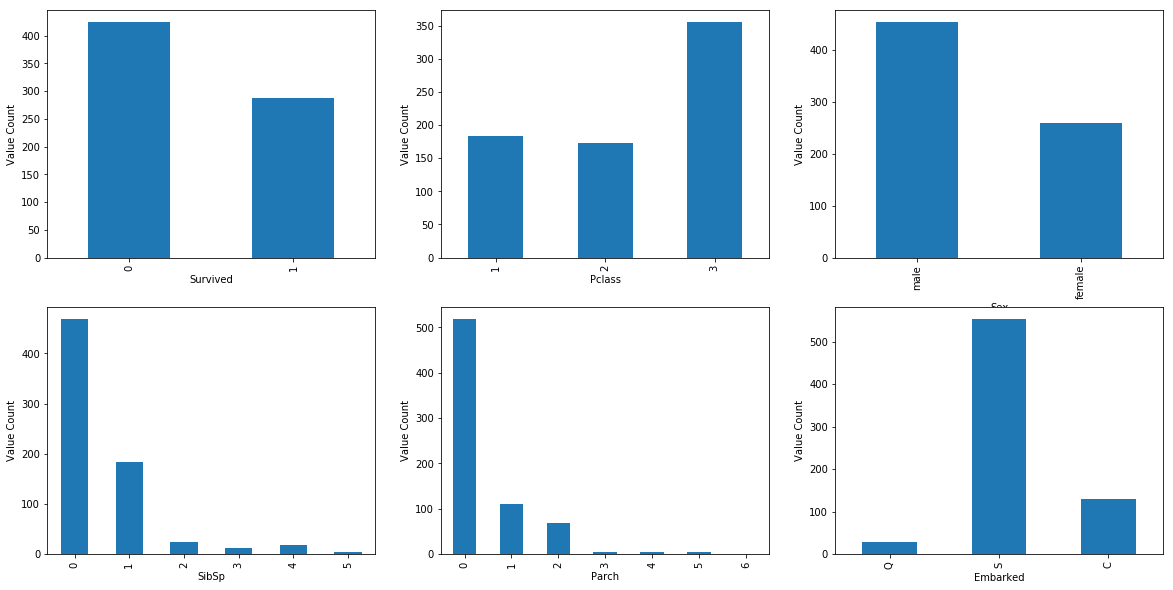

In [6]:
categorical_columns = [
    'Survived', 
    'Pclass', 
    'Sex', 
    'SibSp', 
    'Parch', 
    'Embarked'
]

num_cols = 3
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(categorical_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[categorical_columns[col]].value_counts(sort=False).plot(kind='bar')
    plt.xlabel(categorical_columns[col])
    plt.ylabel('Value Count')
plt.show()

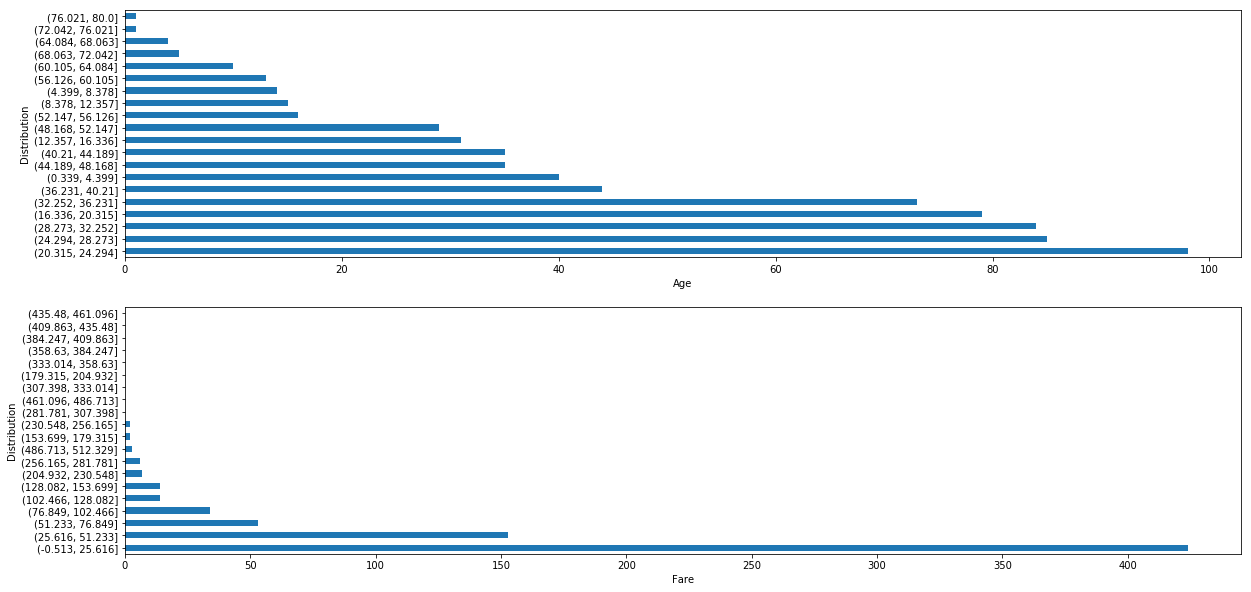

In [7]:
continuous_variables = [
    'Age', 
    'Fare'
]

num_cols = 1
num_rows = math.ceil(len(categorical_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(continuous_variables)):    
    plt.subplot(num_rows, num_cols, col+1)
    df_data[continuous_variables[col]].value_counts(bins=20, sort=True).plot(kind='barh')
    plt.xlabel(continuous_variables[col])
    plt.ylabel('Distribution')
plt.show()


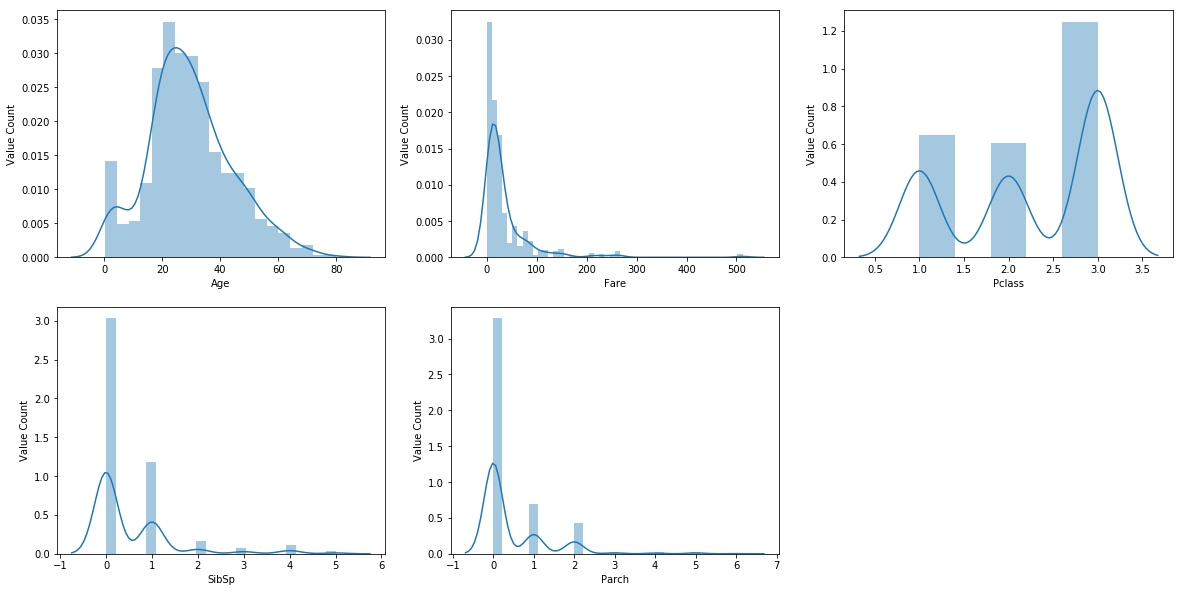

In [8]:
dist_columns = [
    'Age',
    'Fare',
    'Pclass',
    'SibSp',
    'Parch'
]

num_cols = 3
num_rows = math.ceil(len(dist_columns)/3)

plt.figure(figsize=(20, 5*num_rows))

for col in range(len(dist_columns)):    
    plt.subplot(num_rows, num_cols, col+1)
    sns.distplot(df_data[dist_columns[col]])
    plt.xlabel(dist_columns[col])
    plt.ylabel('Value Count')
plt.show()

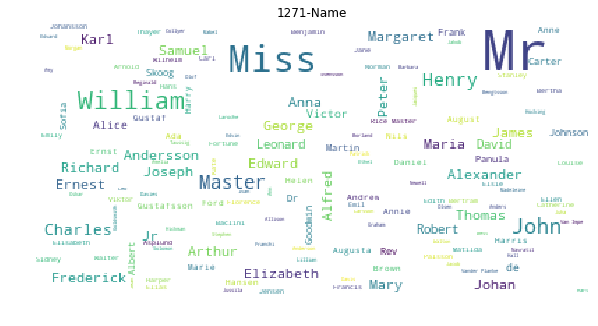

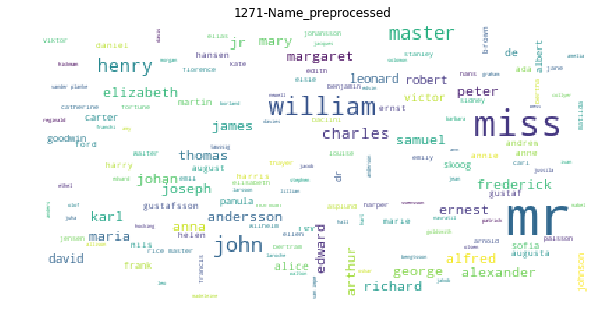

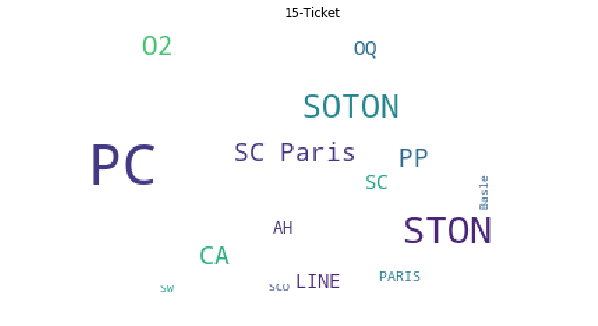

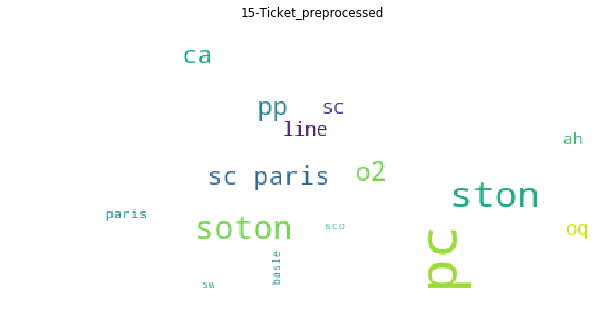

In [9]:
text_columns = ['Name', 'Name_preprocessed', 'Ticket', 'Ticket_preprocessed']

for col in range(len(text_columns)):
    si=StringIO()
    df_data[text_columns[col]].apply(lambda x: si.write(str(x) + " "))
    text=si.getvalue()
    si.close()

    wordcloud = WordCloud(width=1600, height=1600, max_words=100).generate(text)
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40, 
        relative_scaling=.5
    ).generate(text)
    plt.figure(figsize=(10, 20))
    plt.imshow(wordcloud)
    plt.title("{}-{}".format(str(len(wordcloud.words_)), text_columns[col]))
    plt.axis("off")
    plt.show()

### Definition of Ally and Adversary Variables.
- Ally target: Survived
- Adversary target: Sex
- The choice of adversary target can be changed.
- Chosen M/F here as it will be possible to have train-test split or k-fold validation

In [10]:
for col in ["Name", "Sex", "Embarked", "Ticket"]:
    df_data[col] = df_data[col+"_preprocessed"]
    df_data.drop([col+"_preprocessed"], axis=1, inplace=True)
df_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,braund mr owen harris,male,22.0,1,0,a 5 21171,7.2500,s
1,2,1,1,cumings mrs john bradley florence briggs thayer,female,38.0,1,0,pc 17599,71.2833,c
2,3,1,3,heikkinen miss laina,female,26.0,0,0,ston o2 3101282,7.9250,s


In [11]:
df_data = pd.get_dummies(df_data, columns=['Sex'], drop_first=True)
df_data = pd.get_dummies(df_data, columns=['Pclass', 'SibSp', 'Parch', 'Embarked'])
df_data.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,Sex_male,Pclass_1,Pclass_2,Pclass_3,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,1,0,braund mr owen harris,22.0,a 5 21171,7.2500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,2,1,cumings mrs john bradley florence briggs thayer,38.0,pc 17599,71.2833,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1,heikkinen miss laina,26.0,ston o2 3101282,7.9250,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1,futrelle mrs jacques heath lily may peel,35.0,113803,53.1000,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
4,5,0,allen mr william henry,35.0,373450,8.0500,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [12]:
y_ally = np.array(df_data.Survived.tolist())
y_advr = np.array(df_data.Sex_male.tolist())

df_data.drop(['Survived', 'Sex_male'], axis=1, inplace=True)

- using One hot encoding to convert the categorical data into dummy variables.
- Alternatively: [Managing categorical variables in pandas dataframe](http://benalexkeen.com/mapping-categorical-data-in-pandas/)
- Using count vectorizer to convert the text data into features based on bow model.

In [13]:
vectorizer = CountVectorizer()
Name = vectorizer.fit_transform(df_data.Name.tolist()).toarray()
vectorizer = CountVectorizer(vocabulary=wordcloud.words_.keys())
Ticket = vectorizer.fit_transform(df_data.Ticket.tolist()).toarray()

In [14]:
df_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
df_data.head(3)

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_c,Embarked_q,Embarked_s
0,22.0,7.2500,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,26.0,7.9250,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [15]:
X = np.concatenate((df_data.values, Name, Ticket), axis=1)
y_ally.shape, y_advr.shape, X.shape

((712,), (712,), (712, 1324))

### Train Test Split

- This step is required before the Scaling or PCA is learnt on the train dataset and then used to transform the test dataset.

In [16]:
X_train, X_valid, y_ally_train, y_ally_valid, y_advr_train, y_advr_valid = train_test_split(
    X, 
    y_ally,
    y_advr,
    test_size=0.1,
    stratify=pd.DataFrame(np.concatenate((y_ally.reshape(-1, 1), y_advr.reshape(-1, 1)), axis=1))
)
X_train.shape, X_valid.shape, y_ally_train.shape, y_ally_valid.shape, y_advr_train.shape, y_advr_valid.shape

((640, 1324), (72, 1324), (640,), (72,), (640,), (72,))

### Checking the distribution after the split

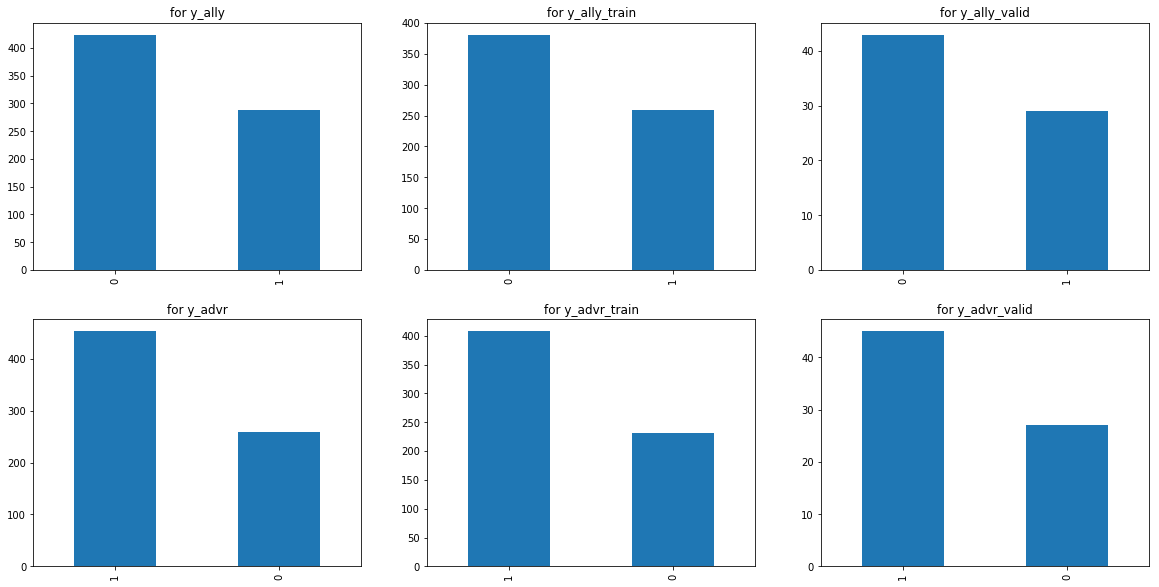

In [17]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
pd.value_counts(y_ally).plot(kind='bar')
plt.title('for y_ally')
plt.subplot(2, 3, 2)
pd.value_counts(y_ally_train).plot(kind='bar')
plt.title('for y_ally_train')
plt.subplot(2, 3, 3)
pd.value_counts(y_ally_valid).plot(kind='bar')
plt.title('for y_ally_valid')
plt.subplot(2, 3, 4)
pd.value_counts(y_advr).plot(kind='bar')
plt.title('for y_advr')
plt.subplot(2, 3, 5)
pd.value_counts(y_advr_train).plot(kind='bar')
plt.title('for y_advr_train')
plt.subplot(2, 3, 6)
pd.value_counts(y_advr_valid).plot(kind='bar')
plt.title('for y_advr_valid')
plt.show()

### Scaler
- Perform minmax scaling for removing the skewness which might effect the gradient descent during neural network training. 
- It is necessary to do this scaling before PCA is applied

In [18]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_valid_normalized = scaler.transform(X_valid)

### Apply PCA and select components using explained variances

In [19]:
pca = PCA()
X_train_reduced = pca.fit_transform(X_train_normalized)

In [22]:
num_components = 0
total_var = 0
variance_threshold = 0.99
for _ in pca.explained_variance_ratio_:
    total_var += _
    num_components += 1
    if total_var > variance_threshold:
        break
print(total_var, num_components)

0.9900447873430933 588


In [23]:
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_normalized)
X_valid_reduced = pca.transform(X_valid_normalized)
X_train_reduced.shape, X_valid_reduced.shape

((640, 588), (72, 588))

### Apply Auto-encoder for dimensionality reduction

In [24]:
import torch
import torch.utils.data as utils
import torch.nn as nn

In [26]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("DType: {}\nCuda available: {}\nDevice: {}".format(
    dtype.__str__(),
    torch.cuda.is_available().__str__(),
    device.__str__(),
))

X_train_torch = torch.Tensor(X_train_normalized)
X_valid_torch = torch.Tensor(X_valid_normalized)
y_ally_train_torch = torch.Tensor(y_ally_train.reshape(-1, 1))
y_ally_valid_torch = torch.Tensor(y_ally_valid.reshape(-1, 1))
y_advr_train_torch = torch.Tensor(y_advr_train.reshape(-1, 1))
y_advr_valid_torch = torch.Tensor(y_advr_valid.reshape(-1, 1))

DType: torch.float32
Cuda available: True
Device: cuda


In [27]:
X_train_torch.shape, X_valid_torch.shape, \
y_ally_train_torch.shape, y_ally_valid_torch.shape, \
y_advr_train_torch.shape, y_advr_valid_torch.shape

(torch.Size([640, 1324]),
 torch.Size([72, 1324]),
 torch.Size([640, 1]),
 torch.Size([72, 1]),
 torch.Size([640, 1]),
 torch.Size([72, 1]))

In [37]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.relu(self.fc1(x))

    def decoder(self, y):
        return self.sigmoid(self.fc2(y))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [42]:
auto_encoder = AutoEncoder(input_size=1324, encoding_dim=588)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.001)

In [43]:
print("epoch \t Aencoder_train \t Aencoder_valid")

for epoch in range(501):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_train_torch_hat = auto_encoder(X_train_torch)
    ae_loss = criterion(X_train_torch_hat, X_train_torch)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    if epoch%50!=0:
        continue
        
    auto_encoder.eval()
    
    X_valid_torch_hat = auto_encoder(X_valid_torch)
    ae_valid_loss = criterion(X_valid_torch_hat, X_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
        ae_valid_loss
    ))

epoch 	 Aencoder_train 	 Aencoder_valid
0 	 0.97379804 	 0.97213018
50 	 0.68155843 	 0.69776261
100 	 0.67480820 	 0.69400716
150 	 0.67147642 	 0.69119143
200 	 0.66936797 	 0.68943208
250 	 0.66785812 	 0.68838054
300 	 0.66669595 	 0.68768883
350 	 0.66587806 	 0.68687105
400 	 0.66525918 	 0.68648827
450 	 0.66442877 	 0.68622351
500 	 0.66395754 	 0.68590081


In [44]:
auto_encoder.eval()
X_train_torch_ae = auto_encoder.encoder(X_train_torch)
X_valid_torch_ae = auto_encoder.encoder(X_valid_torch)
X_train_torch_ae.shape, X_valid_torch_ae.shape

(torch.Size([640, 588]), torch.Size([72, 588]))

# GAN using Pytorch

- ["**Learning Informative and Private Representations via Generative Adversarial Networks**"](http://www.princeton.edu/~pmittal/publications/gan-bigdata18.pdf)

### GAN V1

```python
encd_N = 64 
encd_D_in = X.shape[1]
encd_H = int(encd_D_in/2)
encd_D_out = 64

# encoder
encd_w1 = torch.randn(encd_D_in, encd_H, device=device, dtype=dtype, requires_grad=True)
encd_w2 = torch.randn(encd_H, encd_D_out, device=device, dtype=dtype, requires_grad=True)

ally_N = 64 
ally_D_in = encd_D_out
ally_H = int(ally_D_in/2)
ally_D_out = 1

# ally
ally_w1 = torch.randn(ally_D_in, ally_H, device=device, dtype=dtype, requires_grad=True)
ally_w2 = torch.randn(ally_H, ally_D_out, device=device, dtype=dtype, requires_grad=True)

advr_N = 64 
advr_D_in = encd_D_out
advr_H = int(advr_D_in/2)
advr_D_out = 2

# advr
advr_w1 = torch.randn(advr_D_in, advr_H, device=device, dtype=dtype, requires_grad=True)
advr_w2 = torch.randn(advr_H, advr_D_out, device=device, dtype=dtype, requires_grad=True)
```

### GAN V2

In [31]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [32]:
alpha = 0.5

In [33]:
encoding_dimension = 586
encoder = Encoder(input_size=X_train_torch.shape[1], hidden_size=1024, output_size=encoding_dimension)
ally = Ally(input_size=encoding_dimension, hidden_size=128, output_size=y_ally_train_torch.shape[1])
adversary = Adversary(input_size=encoding_dimension, hidden_size=128, output_size=y_advr_train_torch.shape[1])

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
encd_optimizer = optimizer(encoder.parameters(), lr = 0.001)
ally_optimizer = optimizer(ally.parameters(), lr=0.001)
advr_optimizer = optimizer(adversary.parameters(), lr=0.001)

In [152]:
print("epoch \t encoder_train \t encoder_valid \t ally_train \t ally_valid \t advr_train \t advr_valid")

for epoch in range(501):
    # set for training
    encoder.train()
    ally.train()
    adversary.train()
    
    encd_optimizer.zero_grad()
    # Forward passv
    X_train_encoding = encoder(X_train_torch)
    y_ally_train_torch_hat = ally(X_train_encoding)
    y_advr_train_torch_hat = adversary(X_train_encoding)
    # Compute Loss
    ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    encd_loss = alpha * ally_loss - (1-alpha) * advr_loss
    # Backward pass
    encd_loss.backward(retain_graph=True)
    encd_optimizer.step()

    for i in range(10):
        ally_optimizer.zero_grad()
        advr_optimizer.zero_grad()

        X_train_encoding = encoder(X_train_torch)
        y_ally_train_torch_hat = ally(X_train_encoding)
        y_advr_train_torch_hat = adversary(X_train_encoding)
        
        ally_loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
        advr_loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
        
        ally_loss.backward(retain_graph=True)
        advr_loss.backward(retain_graph=True)

        ally_optimizer.step()
        advr_optimizer.step()
        
    if epoch%50!=0:
        continue

    # set for eval
    encoder.eval()
    ally.eval()
    adversary.eval()
    
    X_valid_encoding = encoder(X_valid_torch)
    y_ally_valid_torch_hat = ally(X_valid_encoding)
    y_advr_valid_torch_hat = adversary(X_valid_encoding)

    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    encd_valid_loss = alpha * ally_loss / ((1-alpha) * advr_loss)
        
    print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        encd_loss.item(),
        encd_valid_loss,
        ally_loss.item(), 
        ally_valid_loss,
        advr_loss.item(),
        advr_valid_loss,
    ))

epoch 	 encoder_train 	 encoder_valid 	 ally_train 	 ally_valid 	 advr_train 	 advr_valid
0 	 0.06445310 	 1.06223249 	 0.69409955 	 0.69385648 	 0.65343469 	 0.66117537
50 	 0.04634932 	 1.07822239 	 0.64804953 	 0.68969214 	 0.60103512 	 0.62705272
100 	 -0.05582017 	 0.82976288 	 0.54399967 	 0.68993145 	 0.65560859 	 0.68166423
150 	 -0.06136438 	 0.82072324 	 0.56200117 	 0.69706953 	 0.68476331 	 0.69164532
200 	 -0.05749002 	 0.82985121 	 0.56078178 	 0.68740332 	 0.67576182 	 0.68826175
250 	 -0.05749029 	 0.82985044 	 0.56078124 	 0.68503571 	 0.67576182 	 0.68826175
300 	 -0.05749032 	 0.82985038 	 0.56078118 	 0.68431026 	 0.67576182 	 0.68826175
350 	 -0.05749035 	 0.82985026 	 0.56078112 	 0.68392032 	 0.67576182 	 0.68826175
400 	 -0.05749038 	 0.82985020 	 0.56078106 	 0.68366295 	 0.67576182 	 0.68826175
450 	 -0.05749041 	 0.82985008 	 0.56078100 	 0.68346983 	 0.67576182 	 0.68826175
500 	 -0.05749041 	 0.82985008 	 0.56078100 	 0.68331003 	 0.67576182 	 0.68826175


# Ally and Adversary Learning on Encoded Data

In [153]:
X_train_encoded = encoder(X_train_torch)
X_valid_encoded = encoder(X_valid_torch)
X_train_encoded.shape, X_valid_encoded.shape

(torch.Size([640, 586]), torch.Size([72, 586]))

In [154]:
X_train_reduced.shape, X_valid_reduced.shape

((640, 586), (72, 586))

In [155]:
y_ally_train_torch.shape, y_ally_valid_torch.shape

(torch.Size([640, 1]), torch.Size([72, 1]))

In [46]:
class Network(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.sigmoid(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [157]:
lr = 0.01

network = Network(586, 128, 1)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

for epoch in range(501):
    network.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network(X_train_encoded)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network.eval()
    y_ally_valid_torch_hat = network(X_valid_encoded)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))

epoch 	 ally_train 	 ally_valid
0 	 0.76707399 	 0.69711125
50 	 0.57872862 	 0.69281191
100 	 0.56094491 	 0.68535924
150 	 0.56086284 	 0.68441713
200 	 0.56083727 	 0.68421483
250 	 0.56082231 	 0.68404013
300 	 0.56081313 	 0.68390518
350 	 0.56080699 	 0.68378955
400 	 0.56080252 	 0.68368292
450 	 0.56079912 	 0.68358135
500 	 0.56079662 	 0.68348598


In [158]:
lr = 0.001

network_advr = Network(586, 128, 1)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

for epoch in range(501):
    network_advr.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr(X_train_encoded)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr.eval()
    y_advr_valid_torch_hat = network_advr(X_valid_encoded)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))

epoch 	 advr_train 	 advr_valid
0 	 0.65722281 	 0.65887523
50 	 0.57263184 	 0.64836919
100 	 0.51717401 	 0.64483142
150 	 0.49495667 	 0.62840039
200 	 0.48336449 	 0.61452413
250 	 0.47725582 	 0.60762876
300 	 0.47342277 	 0.60279089
350 	 0.47066832 	 0.60003889
400 	 0.46868688 	 0.59716433
450 	 0.46715945 	 0.59479982
500 	 0.46577516 	 0.59206682


# Ally and Adversary Learning on PCA Data

In [159]:
X_train_pca_torch = torch.Tensor(X_train_reduced)
X_valid_pca_torch = torch.Tensor(X_valid_reduced)

In [160]:
lr = 0.01

network_ally_pca = Network(586, 128, 1)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_pca.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

for epoch in range(501):
    network_ally_pca.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_pca(X_train_pca_torch)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_pca.eval()
    y_ally_valid_torch_hat = network_ally_pca(X_valid_pca_torch)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))

epoch 	 ally_train 	 ally_valid
0 	 0.75883895 	 0.72257191
50 	 0.54731607 	 0.68798012
100 	 0.54653543 	 0.69100267
150 	 0.54545796 	 0.69158185
200 	 0.54482198 	 0.69177139
250 	 0.54480267 	 0.69185305
300 	 0.54479188 	 0.69198304
350 	 0.54478472 	 0.69215852
400 	 0.54477942 	 0.69230789
450 	 0.54477566 	 0.69246650
500 	 0.54477274 	 0.69263625


In [161]:
lr = 0.001

network_advr_pca = Network(586, 128, 1)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_pca.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

for epoch in range(501):
    network_advr_pca.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_pca(X_train_pca_torch)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_pca.eval()
    y_advr_valid_torch_hat = network_advr_pca(X_valid_pca_torch)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))

epoch 	 advr_train 	 advr_valid
0 	 0.65510893 	 0.65946668
50 	 0.49789247 	 0.54325426
100 	 0.46523571 	 0.51409227
150 	 0.46137077 	 0.50685185
200 	 0.46016446 	 0.50355554
250 	 0.45959130 	 0.50158882
300 	 0.45926514 	 0.50024784
350 	 0.45905885 	 0.49926811
400 	 0.45891780 	 0.49851623
450 	 0.45881668 	 0.49792275
500 	 0.45874196 	 0.49743494


# Ally and Adversary Training on Auto-encoded data

In [48]:
lr = 0.001

network_ally_ae = Network(588, 128, 1)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_ally_ae.parameters(), lr=lr)    

print("epoch \t ally_train \t ally_valid")

for epoch in range(501):
    network_ally_ae.train()
    net_optimizer.zero_grad()
    
    y_ally_train_torch_hat = network_ally_ae(X_train_torch_ae)
    loss = criterion(y_ally_train_torch_hat, y_ally_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_ally_ae.eval()
    y_ally_valid_torch_hat = network_ally_ae(X_valid_torch_ae)
    ally_valid_loss = criterion(y_ally_valid_torch_hat, y_ally_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        ally_valid_loss
    ))

epoch 	 ally_train 	 ally_valid
0 	 0.79124689 	 0.76336694
50 	 0.69495261 	 0.69503969
100 	 0.69397873 	 0.69402921
150 	 0.69357502 	 0.69363588
200 	 0.69338024 	 0.69345599
250 	 0.69326270 	 0.69335192
300 	 0.69316345 	 0.69326961
350 	 0.69302982 	 0.69316334
400 	 0.69272029 	 0.69293523
450 	 0.69041032 	 0.69140476
500 	 0.61044341 	 0.65696937


In [49]:
lr = 0.001

network_advr_ae = Network(588, 128, 1)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam
net_optimizer = optimizer(network_advr_ae.parameters(), lr=lr)    

print("epoch \t advr_train \t advr_valid")

for epoch in range(501):
    network_advr_ae.train()
    net_optimizer.zero_grad()
    
    y_advr_train_torch_hat = network_advr_ae(X_train_torch_ae)
    loss = criterion(y_advr_train_torch_hat, y_advr_train_torch)
    loss.backward(retain_graph = True)
    net_optimizer.step()

    if (epoch)%50!=0:
        continue
    
    # set for eval
    network_advr_ae.eval()
    y_advr_valid_torch_hat = network_advr_ae(X_valid_torch_ae)
    advr_valid_loss = criterion(y_advr_valid_torch_hat, y_advr_valid_torch)
    
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch,  
        loss.item(),
        advr_valid_loss
    ))

epoch 	 advr_train 	 advr_valid
0 	 0.65650511 	 0.65800893
50 	 0.48331529 	 0.54573488
100 	 0.45943126 	 0.52933824
150 	 0.45590931 	 0.52566308
200 	 0.45477781 	 0.52378529
250 	 0.45424351 	 0.52264071
300 	 0.45394212 	 0.52186680
350 	 0.45375291 	 0.52130812
400 	 0.45362526 	 0.52088737
450 	 0.45353451 	 0.52056050
500 	 0.45346737 	 0.52030081


# Results

| Model | Train Ally  | Valid Ally  | Train Advr | Valid Advr |
|---|---:|---:|---:|---:|
| PCA | **0.54477274** | 0.69263625 | 0.45874196 | 0.49743494 |
| A-Enc | 0.61044341 | **0.65696937** | 0.45346737 | 0.52030081 |
| P-GAN | 0.56079662 | 0.68348598 | **0.46577516** | **0.59206682** |